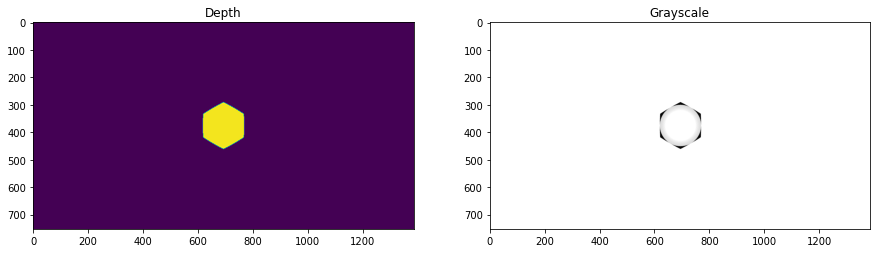

In [2]:
# read in untransformed bolt
# The untransformed location of the bolt is such that the center of the head is at 0,0,0
# and it is pointing in the direction and centered on the positive x axis.
# For example, rotating it around the z axis 90 degrees will make it appear pointing left
from utility.pose_data import get_bolt_depthimage, show_depthimage, make_pointcloud, get_random_transform
from utility.transformation_matrix import TransformationMatrix
from utility.visualizer import visualizer as vis

depthimage = get_bolt_depthimage()
show_depthimage(depthimage)

x=0.0, y=0.0, z=0.0
x_rotate=0.0°, y_rotate=0.0°, z_rotate=90.0°


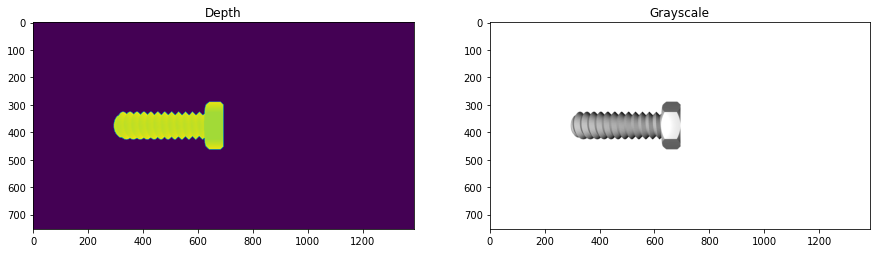

In [3]:
transform = TransformationMatrix.from_xyzwpr([0,0,0,0,0,90])
print(transform)
depthimage = get_bolt_depthimage(transform)
show_depthimage(depthimage)

x=4.94, y=44.52, z=3.96
x_rotate=0.0°, y_rotate=-2.73°, z_rotate=-5.2°


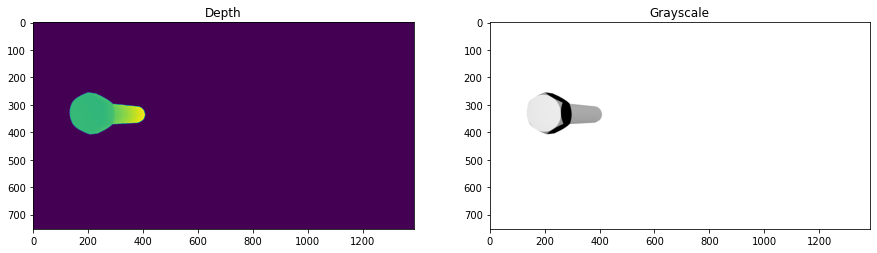

Now I'm a point cloud. Try moving me around!


In [4]:
transform = get_random_transform()
print(transform)
depthimage = get_bolt_depthimage(transform)
show_depthimage(depthimage)
pcd = make_pointcloud(depthimage.depth)
print('Now I\'m a point cloud. Try moving me around!')
vis.draw_geometries([pcd], moveable=False)

Truth
x=0.0, y=0.0, z=10.0
x_rotate=0.0°, y_rotate=20.0°, z_rotate=0.0°


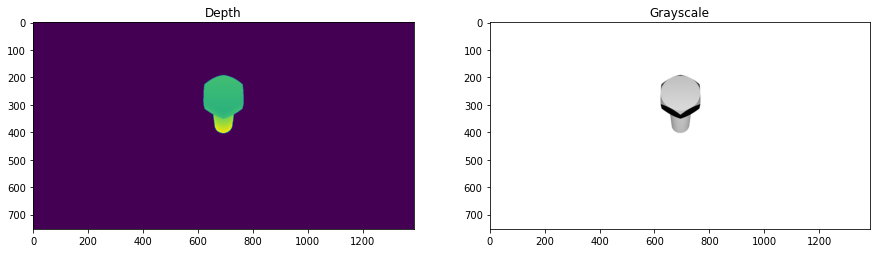

Estimate
x=4.02, y=14.93, z=14.06
x_rotate=0.0°, y_rotate=0.0°, z_rotate=0.0°

Error: 10.453


In [5]:
import numpy as np
from scipy.spatial.transform import Rotation as R


def rotation_between_vectors(u, v):
    # u and v are both 3D unit vectors
    axis = np.cross(u, v)
    unit = axis / np.linalg.norm(axis)
    angle = np.arccos(np.dot(u, v))
    rotvec = unit * angle
    return R.from_rotvec(rotvec)


def estimator(transformed_depthimage, debug=False):
    orig_normal = np.array([1,0,0]) # the bolt head is initially pointed in the x direction
    orig_center = np.array([0,0,0]) # the bolt head is initially centered at 0,0,0

    trns_pcd = make_pointcloud(transformed_depthimage)
    trns_center = trns_pcd.get_center()
    translation = (trns_center - orig_center)
    rot = np.zeros(3) # dummy values
    rot[0] = 0 # the rotation in x_rotate will always be 0 because I made that constraint
    rot = R.from_euler('xyz', rot).as_matrix()
    return TransformationMatrix.compose(rot, translation)

transform = TransformationMatrix.from_xyzwpr([0,0,10,0,20,0])
print('Truth')
print(transform)
transformed = get_bolt_depthimage(transform)
transformed_pcd = make_pointcloud(transformed)

show_depthimage(transformed)
vis.draw_geometries([transformed_pcd], moveable=False)
estimate = estimator(transformed, debug=False)
print('Estimate')
print(estimate)
from utility.pose_estimation import transform_error, evaluate_random

print('\nError:', transform_error(estimate, transform).round(3))

In [6]:
# you can use this convience function to get the loss on a random transformation
evaluate_random(estimator) 

13.280267291379658

In [7]:
from utility.pose_estimation import make_submission, test_images
import os
from tqdm import tqdm
os.environ["DISCORD_USERNAME"] = "josiah"

print('Estimating transformations')
estimates = np.array([estimator(img) for img in tqdm(test_images)])
make_submission(estimates)

Estimating transformations


100%|██████████| 200/200 [00:05<00:00, 38.85it/s]


Mean rmse=6.7376
Your ranking: #1

In [8]:
from utility.scoring_client import get_highscores, get_myscores, Challenge
get_highscores(Challenge.POSE)

Your Ranking: #1
           score
name            
josiah  6.737563

In [9]:
get_myscores(Challenge.POSE)

[6.737563388994877]

# Robot Control Challenge

In [12]:
from utility.remote_env import RobotorqueEnv

env = RobotorqueEnv(Challenge.ROBOT)
state = env.reset()
history = []
for _ in tqdm(list(range(10))):
    robot_positions = [state['bolt_pose'].translation[1]] * env.CONTROLS_PER_CAPTURE
    state, reward, done, info = env.step(robot_positions)
    info['rewards'] = reward
    history.append(info)

import pandas as pd
df = pd.DataFrame(history).round(3)
print(df)
print('Total Reward:', df.rewards.sum().round(1))
print('Ranking', info['ranking'])


  0%|          | 0/10 [00:00<?, ?it/s]

[0. 0. 0.]


 10%|█         | 1/10 [00:00<00:01,  4.62it/s]

[0. 0. 0.]


 20%|██        | 2/10 [00:00<00:01,  4.66it/s]

[0. 0. 0.]


 30%|███       | 3/10 [00:00<00:01,  4.65it/s]

[0. 0. 0.]


 40%|████      | 4/10 [00:00<00:01,  4.65it/s]

[0. 0. 0.]


 50%|█████     | 5/10 [00:01<00:01,  4.66it/s]

[0. 0. 0.]


 60%|██████    | 6/10 [00:01<00:00,  4.65it/s]

[0. 0. 0.]


 70%|███████   | 7/10 [00:01<00:00,  4.64it/s]

[0. 0. 0.]


 80%|████████  | 8/10 [00:01<00:00,  4.59it/s]

[0. 0. 0.]


 90%|█████████ | 9/10 [00:01<00:00,  4.57it/s]

[0. 0. 0.]


100%|██████████| 10/10 [00:02<00:00,  4.60it/s]

   bolt position         robot visited positions  time  rewards
0          9.475  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.02    0.000
1         -7.008  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.04    0.000
2         -2.423  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.06    2.577
3         12.441  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.08    0.000
4         -1.719  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.10    3.281
5         -2.402  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.12    2.598
6         16.408  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.14    0.000
7          6.553  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.16    0.000
8          0.486  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.18    4.514
9         21.311  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  0.20    0.000
Total Reward: 13.0


KeyError: 'ranking'